<a href="https://colab.research.google.com/github/theonlyNischal/ML-DL-Projects-and-Paper-Implementation/blob/master/1_Classic_Neural_Networks_Implementation/1-Lenet-5-Pytorch-Improved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Today, we will implement the classical LeNet-5 architecture in Pytorch. In LeNet-5, 5 means there are 5 learned layers, 2 of them are convolutional layer and remaining 3 are dense/linear layer.

We will give modern improvements to the classical architecture, such as using

- Using max-pooling or ReLUs instead of average pooling.
- Using softmax instead of RBF-based classification


https://d2l.ai/_images/lenet.svg

Fig: Architecture of LeNet-5. Input is a handwritten digit, the output is a probability over 10 possible outcomes.


In [1]:
class ClassicLeNet5(nn.Module):
    def __init__(self, num_classes=10):
        super(ClassicLenet5).__init__()

        # convolutional layers
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=6,
            kernel_size=5,
            padding=0
        )
        self.conv2 = nn.Conv2d(
            in_channels=6,
            out_channels=16,
            kernel_size=5
        )
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

        # FC layers
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.tanh(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = torch.tanh(x)
        x = self.pool(x)

        # Flatten
        x = x.view(x.size(0), -1)


        # FC Layers
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)

        return x

Let's implement modern version of Lenet-5 for MNIST.


In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler




In [3]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [4]:
# Data directory
data_dir = os.path.join(os.getcwd(), "data", "MNIST")

In [5]:
# Calculate data statistics
temp_data = datasets.MNIST(data_dir, train=True, download=True)
mean = temp_data.data.float().mean() / 255
std = temp_data.data.float().std() / 255
print(f"Dataset mean: {mean:.4f}, std: {std:.4f}")

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 491kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.58MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.78MB/s]


Dataset mean: 0.1307, std: 0.3081


In [6]:
# Define transforms

train_transform = transforms.Compose([
    transforms.RandomRotation(5, fill=(0,)),
    transforms.RandomCrop(28, padding=2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std])
    ])

# Test transforms should be deterministic
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std])
])

In [7]:
# Load datasets
train_data = datasets.MNIST(data_dir, train=True, download=True, transform=train_transform)
test_data = datasets.MNIST(data_dir, train=False, download=True, transform=test_transform)


In [8]:

# Create train/validation split
batch_size = 64  # Increased batch size for better training stability
valid_size = 0.10

num_train = len(train_data)
split_point = int(valid_size * num_train)

indices = list(range(num_train))
np.random.shuffle(indices)

train_indices = indices[split_point:]
valid_indices = indices[:split_point]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)  # No shuffle for test


In [9]:

class ImprovedLeNet5(nn.Module):
    """
    Improved LeNet-5 implementation with proper activation placement
    and closer adherence to the original architecture
    """
    def __init__(self, num_classes=10):
        super(ImprovedLeNet5, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)  # Added padding
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # Corrected input size
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

        # Dropout for regularization
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # First convolutional block
        x = self.conv1(x)           # 28x28x1 -> 28x28x6 (with padding)
        x = F.relu(x)               # Apply activation BEFORE pooling
        x = self.pool(x)            # 28x28x6 -> 14x14x6

        # Second convolutional block
        x = self.conv2(x)           # 14x14x6 -> 10x10x16
        x = F.relu(x)               # Apply activation BEFORE pooling
        x = self.pool(x)            # 10x10x16 -> 5x5x16

        # Flatten for fully connected layers
        x = x.view(x.size(0), -1)   # Flatten: 5x5x16 = 400

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)         # Add dropout for regularization
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)             # NO activation on final layer (logits for CrossEntropy)

        return x

# Initialize model
model = ImprovedLeNet5(num_classes=10)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model has {count_parameters(model):,} trainable parameters")


Model has 61,706 trainable parameters


In [10]:
# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(f"Training on: {device}")

Training on: cuda


In [11]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # Added weight decay

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [12]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)

    return running_loss / len(train_loader), 100. * correct / total

def validate_epoch(model, valid_loader, criterion, device):
    """Validate for one epoch"""
    model.eval()  # Important: set to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation for efficiency
        for data, target in valid_loader:
            data, target = data.to(device), target.to(device)

            output = model(data)
            loss = criterion(output, target)

            running_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)

    return running_loss / len(valid_loader), 100. * correct / total


In [13]:
# Training loop
num_epochs = 15
train_losses, train_accuracies = [], []
valid_losses, valid_accuracies = [], []
best_valid_loss = float('inf')

print("Starting training...")
for epoch in range(num_epochs):
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    # Validate
    valid_loss, valid_acc = validate_epoch(model, valid_loader, criterion, device)

    # Update learning rate
    scheduler.step()

    # Store metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_acc)

    print(f'Epoch {epoch+1:2d}/{num_epochs}: '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | '
          f'Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.2f}%')

    # Save best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_lenet5_model.pth')
        print(f'  → New best model saved (Valid Loss: {valid_loss:.4f})')


Starting training...
Epoch  1/15: Train Loss: 0.6319, Train Acc: 79.49% | Valid Loss: 0.1519, Valid Acc: 95.17%
  → New best model saved (Valid Loss: 0.1519)
Epoch  2/15: Train Loss: 0.2479, Train Acc: 93.18% | Valid Loss: 0.1213, Valid Acc: 96.27%
  → New best model saved (Valid Loss: 0.1213)
Epoch  3/15: Train Loss: 0.1939, Train Acc: 94.68% | Valid Loss: 0.0907, Valid Acc: 97.12%
  → New best model saved (Valid Loss: 0.0907)
Epoch  4/15: Train Loss: 0.1586, Train Acc: 95.64% | Valid Loss: 0.0792, Valid Acc: 97.63%
  → New best model saved (Valid Loss: 0.0792)
Epoch  5/15: Train Loss: 0.1409, Train Acc: 96.14% | Valid Loss: 0.0788, Valid Acc: 97.68%
  → New best model saved (Valid Loss: 0.0788)
Epoch  6/15: Train Loss: 0.1342, Train Acc: 96.45% | Valid Loss: 0.0641, Valid Acc: 98.10%
  → New best model saved (Valid Loss: 0.0641)
Epoch  7/15: Train Loss: 0.1260, Train Acc: 96.55% | Valid Loss: 0.0638, Valid Acc: 98.18%
  → New best model saved (Valid Loss: 0.0638)
Epoch  8/15: Train L

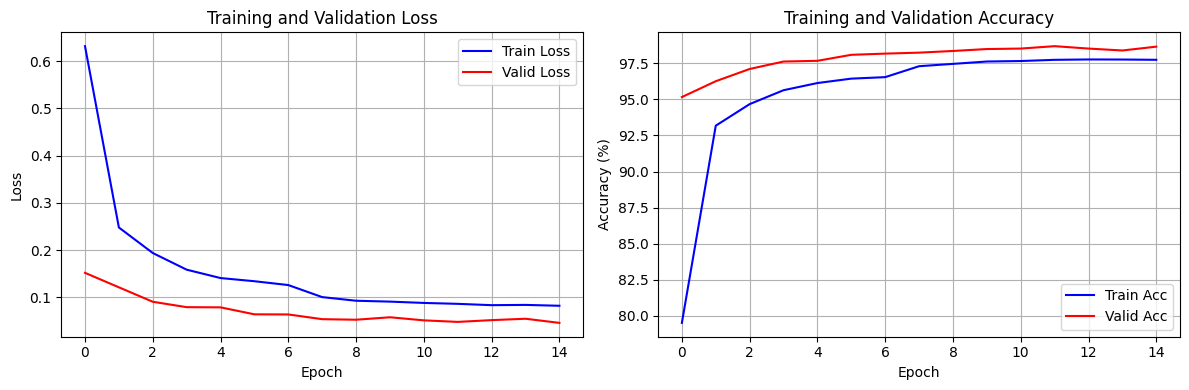

In [14]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(train_losses, label='Train Loss', color='blue')
ax1.plot(valid_losses, label='Valid Loss', color='red')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(train_accuracies, label='Train Acc', color='blue')
ax2.plot(valid_accuracies, label='Valid Acc', color='red')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Test the model
print("\nEvaluating on test set...")
model.load_state_dict(torch.load('best_lenet5_model.pth'))
test_loss, test_acc = validate_epoch(model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')


In [ ]:

# Visualize predictions
def visualize_predictions(model, test_loader, device, num_images=16):
    """Visualize model predictions"""
    model.eval()

    # Get a batch of test images
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    images_gpu = images.to(device)

    # Get predictions
    with torch.no_grad():
        outputs = model(images_gpu)
        _, preds = torch.max(outputs, 1)

    # Convert to CPU for visualization
    images = images.cpu()
    preds = preds.cpu()

    # Plot
    fig, axes = plt.subplots(2, 8, figsize=(16, 4))
    axes = axes.ravel()

    for idx in range(min(num_images, len(images))):
        img = images[idx].squeeze()

        axes[idx].imshow(img, cmap='gray')
        axes[idx].set_title(f'Pred: {preds[idx].item()}, True: {labels[idx].item()}',
                           color='green' if preds[idx] == labels[idx] else 'red')
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

visualize_predictions(model, test_loader, device)